In [98]:
# Kiley Huffman
# QBIO 465
# Assignment 8
# Due: April 10, 2025

# Q1: Data Preparation

● Load each CSV file and reshape the data to match the input requirements of your models, i.e., a 3D array of shape (num_samples, num_time_steps, num_genes).

● Split the data into training and testing sets (80/20 split).

In [101]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Function to load and prepare data
def load_and_prepare_data(filename, num_time_steps, num_genes=10, test_size=0.2): # pre-set num_genes = 10, test_size = 0.2
    # Load the CSV file
    df = pd.read_csv(filename)
    
    # Convert to numpy array
    data = df.to_numpy()
    
    # Extract all features except the last column
    X = data[:, :-1]
    # Get labels from the last column
    y = data[:, -1]
    
    # Reshape features into 3D array: (num_samples, num_time_steps, num_genes)
    num_samples = X.shape[0]
    X = X.reshape((num_samples, num_time_steps, num_genes))
    
    # Split the data into training and testing sets (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    return X_train, X_test, y_train, y_test

# Load all 3 csvs and split into training/test sets
X_train_100, X_test_100, y_train_100, y_test_100 = load_and_prepare_data("gene_expression_data_100.csv", num_time_steps=100)

X_train_200, X_test_200, y_train_200, y_test_200 = load_and_prepare_data("gene_expression_data_200.csv", num_time_steps=200)

X_train_300, X_test_300, y_train_300, y_test_300 = load_and_prepare_data("gene_expression_data_300.csv", num_time_steps=300)



# Q2: LSTM Model Implementation

● Build an LSTM model that accepts input of shape (num_time_steps, num_genes) and outputs a binary classification.

In [106]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Function to build LSTM model that accepts input of shape
def build_lstm_model(input_shape, lstm_units=64, dropout_rate=0.4, learning_rate=0.001):

    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model # Outputs model w/binary classification


● Develop a grid search procedure to tune key hyperparameters (e.g., number of LSTM units, dropout rate, batch size, learning rate, etc.). You may choose which hyperparameters to tune. To reduce computational cost, perform the hyperparameter search using only the gene_expression_data_100.csv dataset.

In [126]:
# Develop a grid search procedure to tune key hyperparameters: 

# Function to build and compile the model with configurable hyperparameters
def build_lstm_model_hp(num_time_steps, num_genes, lstm_units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(LSTM(units=lstm_units, input_shape=(num_time_steps, num_genes)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

from itertools import product

# Define hyperparameter grid
param_grid = {
    'lstm_units': [32, 64],
    'dropout_rate': [0.2, 0.4],
    'batch_size': [32, 64],
    'learning_rate': [1e-3, 1e-4]
}

# Create a list of all combinations
param_combinations = list(product(
    param_grid['lstm_units'],
    param_grid['dropout_rate'],
    param_grid['batch_size'],
    param_grid['learning_rate']
))

# Run grid search with cross-validation on X_train_100
from sklearn.model_selection import KFold
import tensorflow as tf

# Set up KFold
kf = KFold(n_splits=3, shuffle=True, random_state=42)

results = []

for (lstm_units, dropout_rate, batch_size, lr) in param_combinations:
    print(f"Testing: units={lstm_units}, dropout={dropout_rate}, batch={batch_size}, lr={lr}")
    
    val_accuracies = []

    # Perform the hyperparameter search using only the gene_expression_data_100.csv dataset
    for train_idx, val_idx in kf.split(X_train_100):
        X_tr, X_val = X_train_100[train_idx], X_train_100[val_idx]
        y_tr, y_val = y_train_100[train_idx], y_train_100[val_idx]
        
        model = build_lstm_model_hp(
            num_time_steps=100,
            num_genes=10,
            lstm_units=lstm_units,
            dropout_rate=dropout_rate,
            learning_rate=lr
        )
        
        # Train the model
        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=10,
            batch_size=batch_size,
            verbose=0  # turn off progress bar
        )
        
        val_acc = history.history['val_accuracy'][-1]
        val_accuracies.append(val_acc)
    
    avg_val_acc = np.mean(val_accuracies)
    results.append({
        'lstm_units': lstm_units,
        'dropout_rate': dropout_rate,
        'batch_size': batch_size,
        'learning_rate': lr,
        'val_accuracy': avg_val_acc
    })

Testing: units=32, dropout=0.2, batch=32, lr=0.001


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Testing: units=32, dropout=0.2, batch=32, lr=0.0001
Testing: units=32, dropout=0.2, batch=64, lr=0.001
Testing: units=32, dropout=0.2, batch=64, lr=0.0001
Testing: units=32, dropout=0.4, batch=32, lr=0.001
Testing: units=32, dropout=0.4, batch=32, lr=0.0001
Testing: units=32, dropout=0.4, batch=64, lr=0.001
Testing: units=32, dropout=0.4, batch=64, lr=0.0001
Testing: units=64, dropout=0.2, batch=32, lr=0.001
Testing: units=64, dropout=0.2, batch=32, lr=0.0001
Testing: units=64, dropout=0.2, batch=64, lr=0.001
Testing: units=64, dropout=0.2, batch=64, lr=0.0001
Testing: units=64, dropout=0.4, batch=32, lr=0.001
Testing: units=64, dropout=0.4, batch=32, lr=0.0001
Testing: units=64, dropout=0.4, batch=64, lr=0.001
Testing: units=64, dropout=0.4, batch=64, lr=0.0001


● Report the best hyperparameter configuration for the model and discuss the impact of hyperparameter tuning via grid search on the model’s performance.

In [130]:
# Filter results
clean_results = [r for r in results if isinstance(r, dict) and 'val_accuracy' in r]

# Sort results
clean_results = sorted(clean_results, key=lambda x: x['val_accuracy'], reverse=True)

if clean_results:
    print("The best hyperparameter configuration for the model is:")
    print(clean_results[0])

The best hyperparameter configuration for the model is:
{'lstm_units': 32, 'dropout_rate': 0.2, 'batch_size': 32, 'learning_rate': 0.001, 'val_accuracy': 0.6749833424886068}


# Discuss the impact of hyperparameter tuning via grid search on the model’s performance.

Hyperparameter tuning via grid search helped uncover a model configuration that balances learning capacity with generalization, with the following hyperparameters selected:

LSTM Units (32): A moderately sized LSTM layer was able to capture the temporal dynamics of gene expression sequences better than smaller configurations.

Dropout Rate (0.2): A lower dropout rate here is best here

Batch Size (32): Smaller batch sizes allowed for more frequent weight updates, which improved generalization and convergence.

Learning Rate (0.001): This rate enabled efficient learning without overshooting during optimization.

# Q3: Attention-Based Model Implementation

● Build an attention-based model using TensorFlow’s MultiHeadAttention layer, incorporating a residual connection, layer normalization, and a feed-forward network. The model should accept input of shape (num_time_steps, num_genes) and output a binary classification.

In [134]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense, Dropout, Add, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

def build_attention_model(input_shape, num_heads=4, ff_units=128, dropout_rate=0.4, learning_rate=0.001):
    inputs = Input(shape=input_shape)  # shape = (time_steps, num_genes)

    # Project input to ff_units to unify dimensions
    x = Dense(ff_units)(inputs)

    # Multi-head self-attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_units)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    attn_output = Add()([x, attn_output])  # Residual connection
    attn_output = LayerNormalization()(attn_output) # Layer Normalization

    # Feed-forward network
    ff_output = Dense(ff_units, activation='relu')(attn_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = Add()([attn_output, ff_output])  # Residual connection
    ff_output = LayerNormalization()(ff_output) # Layer Normalization

    # Global average pooling + final output
    pooled_output = GlobalAveragePooling1D()(ff_output)
    output = Dense(1, activation='sigmoid')(pooled_output)

    # Build model, binary classification output
    model = Model(inputs=inputs, outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

Develop a grid search procedure to tune key hyperparameters (e.g., number of attention heads, feed-forward dimension, dropout rate, batch size, learning rate, etc.). You may choose which hyperparameters to include. To reduce computational cost, perform the hyperparameter search using only the gene_expression_data_100.csv dataset:

In [34]:
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
import numpy as np

from tensorflow.keras.layers import GlobalAveragePooling1D

def build_attention_model_hp(num_time_steps, num_genes, num_heads, ff_units, dropout_rate, learning_rate):
    inputs = Input(shape=(num_time_steps, num_genes))
    
    # Multi-head attention layer
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=num_genes)(inputs, inputs)
    
    # Residual connection + Layer normalization
    attention_output = LayerNormalization()(attention_output + inputs)
    
    # Feed-forward network (fully connected)
    ff_output = Dense(ff_units, activation='relu')(attention_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = Dense(num_genes)(ff_output)
    
    # Residual connection + Layer normalization
    attention_output = LayerNormalization()(ff_output + attention_output)
    
    # Global average pooling to reduce time steps dimension
    pooled_output = GlobalAveragePooling1D()(attention_output)
    
    # Final classification layer
    output = Dense(1, activation='sigmoid')(pooled_output)  # Binary classification
    
    # Create the model
    model = Model(inputs, output)
    
    # Compile the model with the given learning rate
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


# Develop a grid search procedure to tune hp
# number of attention heads, feed-forward dimension, dropout rate, batch size, learning rate, etc.
param_grid = {
    'num_heads': [4, 8],
    'ff_units': [64, 128],
    'dropout_rate': [0.2, 0.4],
    'batch_size': [32, 64],
    'learning_rate': [1e-3, 1e-4]
}

from itertools import product

param_combinations = list(product(
    param_grid['num_heads'],
    param_grid['ff_units'],
    param_grid['dropout_rate'],
    param_grid['batch_size'],
    param_grid['learning_rate']
))

kf = KFold(n_splits=3, shuffle=True, random_state=42)

results = []

# Loop over all combinations of hyperparameters
for (num_heads, ff_units, dropout_rate, batch_size, learning_rate) in param_combinations:
    print(f"Testing: heads={num_heads}, ff_units={ff_units}, dropout={dropout_rate}, batch_size={batch_size}, lr={learning_rate}")
    
    val_accuracies = []
    # Perform the hyperparameter search using only the gene_expression_data_100.csv dataset.
    for train_idx, val_idx in kf.split(X_train_100):
        X_tr, X_val = X_train_100[train_idx], X_train_100[val_idx]
        y_tr, y_val = y_train_100[train_idx], y_train_100[val_idx]
        
        # Build and compile the attention model with current hyperparameters
        model = build_attention_model_hp(
            num_time_steps=100,
            num_genes=10,
            num_heads=num_heads,
            ff_units=ff_units,
            dropout_rate=dropout_rate,
            learning_rate=learning_rate
        )
        
        # Train the model
        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=10,
            batch_size=batch_size,
            verbose=0  # Disable verbose output
        )
        
        val_acc = history.history['val_accuracy'][-1]
        val_accuracies.append(val_acc)
    
    avg_val_acc = np.mean(val_accuracies)
    results.append({
        'num_heads': num_heads,
        'ff_units': ff_units,
        'dropout_rate': dropout_rate,
        'batch_size': batch_size,
        'learning_rate': learning_rate,
        'val_accuracy': avg_val_acc
    })

Testing: heads=4, ff_units=64, dropout=0.2, batch_size=32, lr=0.001
Testing: heads=4, ff_units=64, dropout=0.2, batch_size=32, lr=0.0001
Testing: heads=4, ff_units=64, dropout=0.2, batch_size=64, lr=0.001
Testing: heads=4, ff_units=64, dropout=0.2, batch_size=64, lr=0.0001
Testing: heads=4, ff_units=64, dropout=0.4, batch_size=32, lr=0.001
Testing: heads=4, ff_units=64, dropout=0.4, batch_size=32, lr=0.0001
Testing: heads=4, ff_units=64, dropout=0.4, batch_size=64, lr=0.001
Testing: heads=4, ff_units=64, dropout=0.4, batch_size=64, lr=0.0001
Testing: heads=4, ff_units=128, dropout=0.2, batch_size=32, lr=0.001
Testing: heads=4, ff_units=128, dropout=0.2, batch_size=32, lr=0.0001
Testing: heads=4, ff_units=128, dropout=0.2, batch_size=64, lr=0.001
Testing: heads=4, ff_units=128, dropout=0.2, batch_size=64, lr=0.0001
Testing: heads=4, ff_units=128, dropout=0.4, batch_size=32, lr=0.001
Testing: heads=4, ff_units=128, dropout=0.4, batch_size=32, lr=0.0001
Testing: heads=4, ff_units=128, dro

● Report the best hyperparameter configuration for the model and discuss the impact of hyperparameter tuning via grid search on the model’s performance.

In [37]:
# Sort results by validation accuracy
results = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)

# Print the best configuration
best_config = results[0]
print("This is the best hyperparameter configuration for the model:")
print(best_config)

This is the best hyperparameter configuration for the model:
{'num_heads': 4, 'ff_units': 128, 'dropout_rate': 0.4, 'batch_size': 32, 'learning_rate': 0.001, 'val_accuracy': 0.6637380123138428}


# Discuss the impact of hyperparameter tuning via grid search on the model’s performance.

The best hyperparameter configuration achieved via grid search had a validation accuracy of approximately 66.37%. Here, 4 attention heads provided sufficient capacity to capture complex temporal dependencies in gene expression sequences. The feed-forward network size of 128 units enabled the model to learn more abstract representations without overfitting when paired with dropout. Moreover, the dropout rate of 0.4 introduced strong regularization. The batch size of 32 and a learning rate of 0.001 offered a good balance between convergence speed and stability during training. Although the validation accuracy is slightly lower than the LSTM model’s best configuration, the attention model brings better interpretability and scalability for longer sequences. 

# Q4: Training and Evaluation 

● Train both the LSTM and Attention models on all three datasets (with 100, 200, and 300 time steps) using the best hyperparameters identified from your grid search.

● For each training run, plot the training and validation accuracy and loss curves.


Training for 100 time steps


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


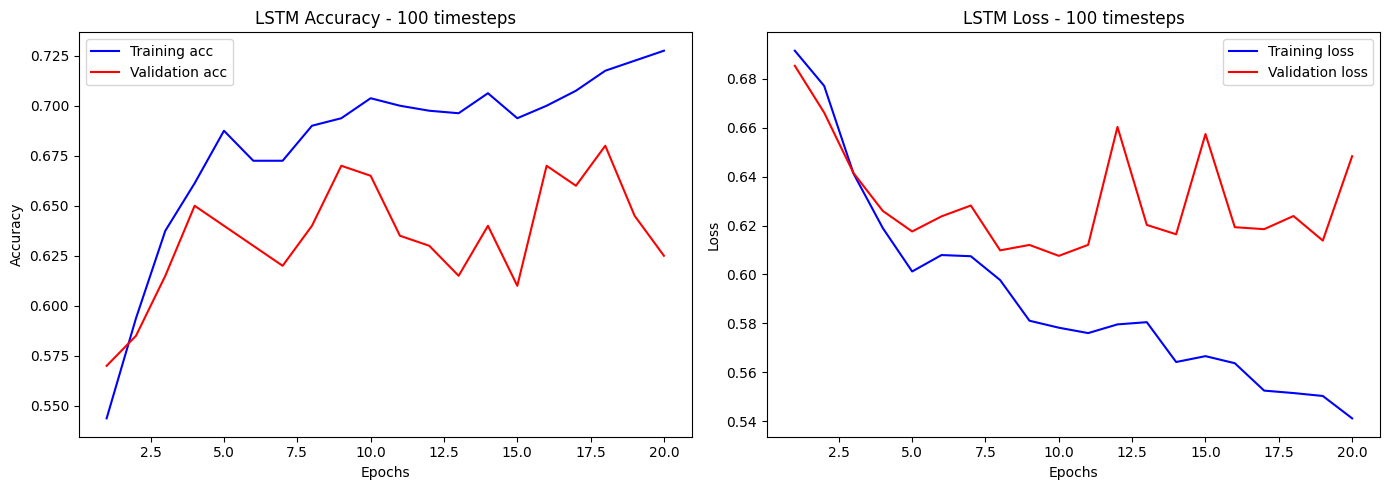

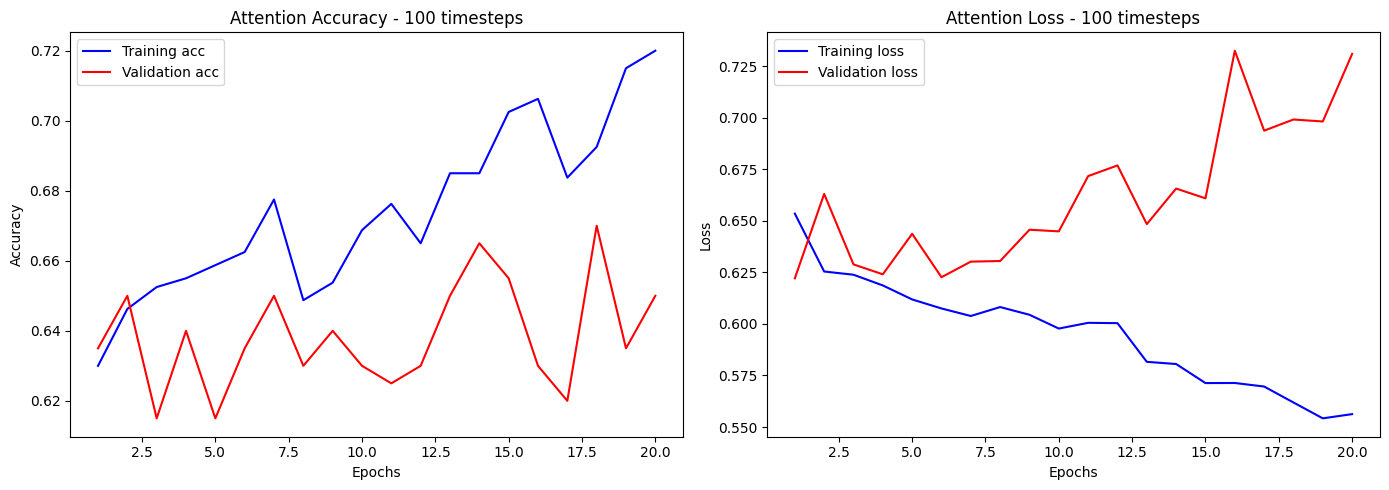


Training for 200 time steps


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


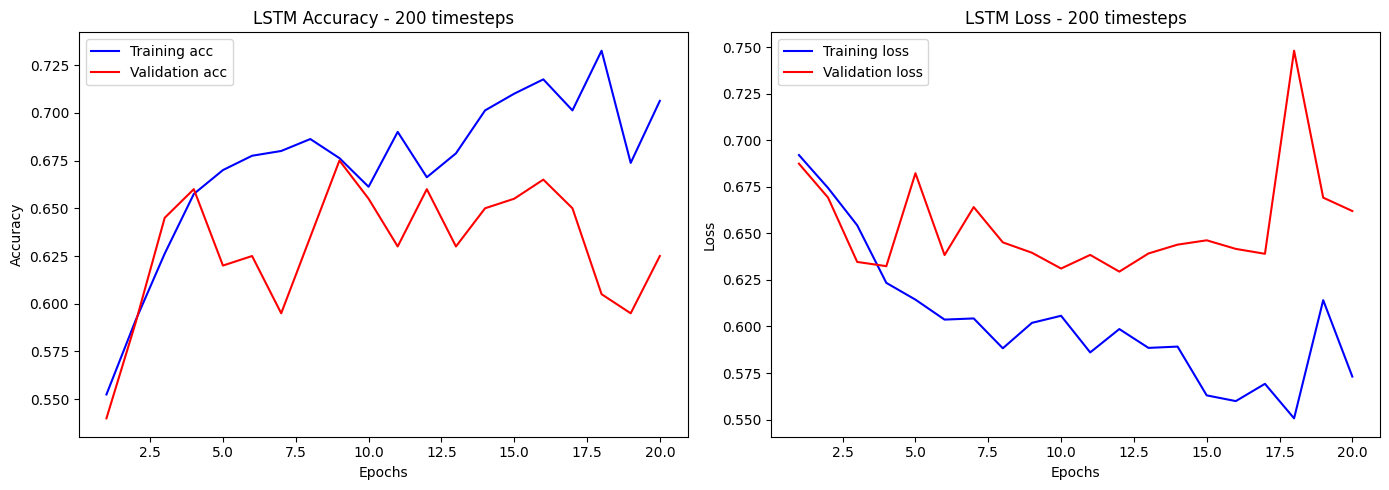

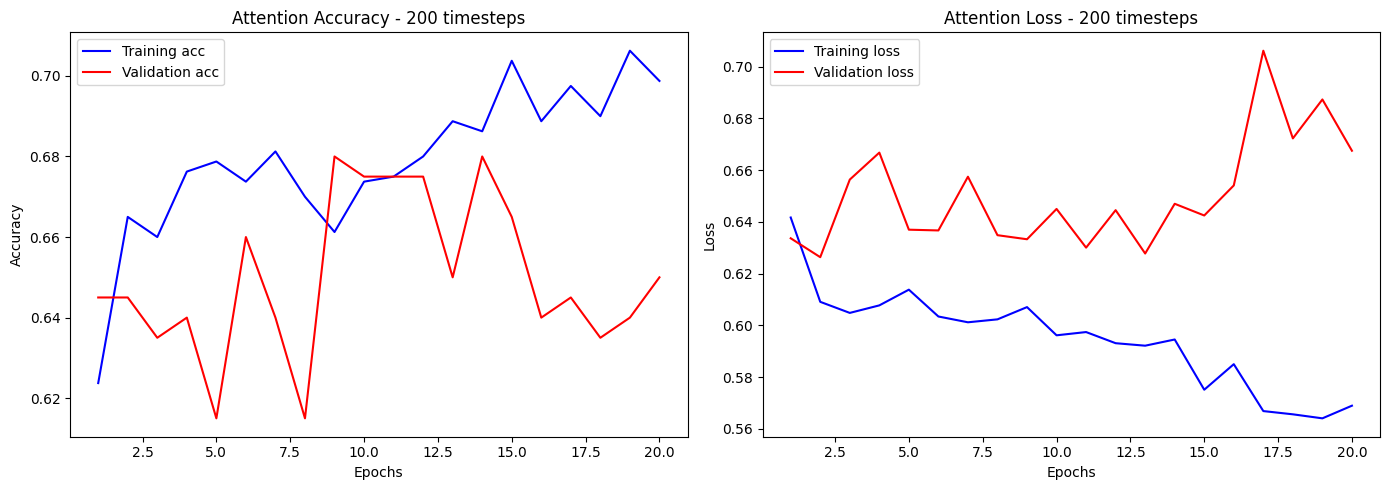


Training for 300 time steps


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


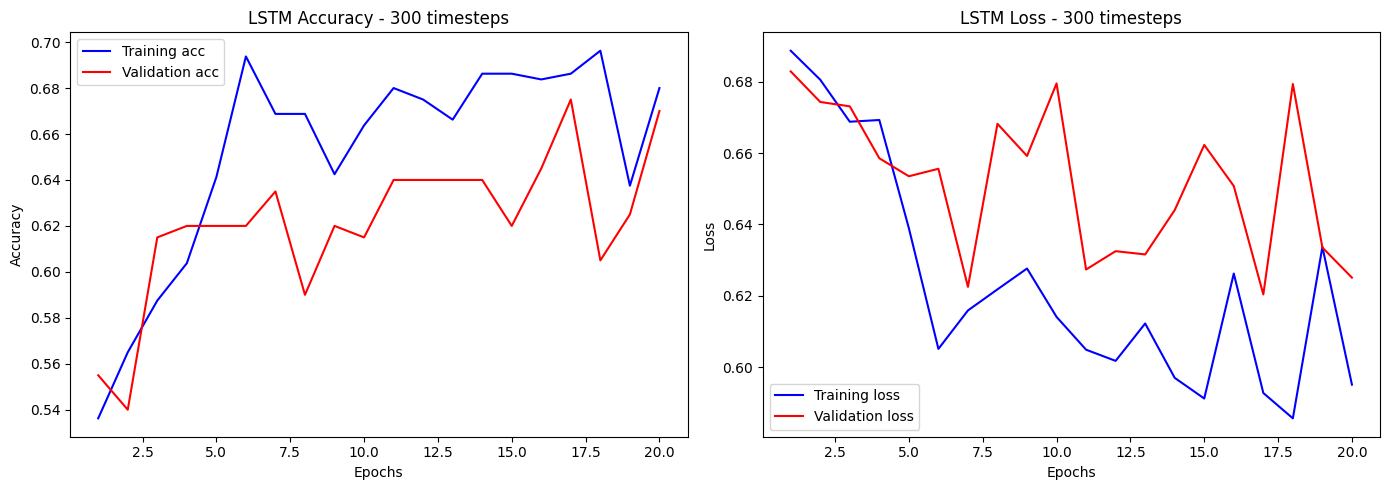

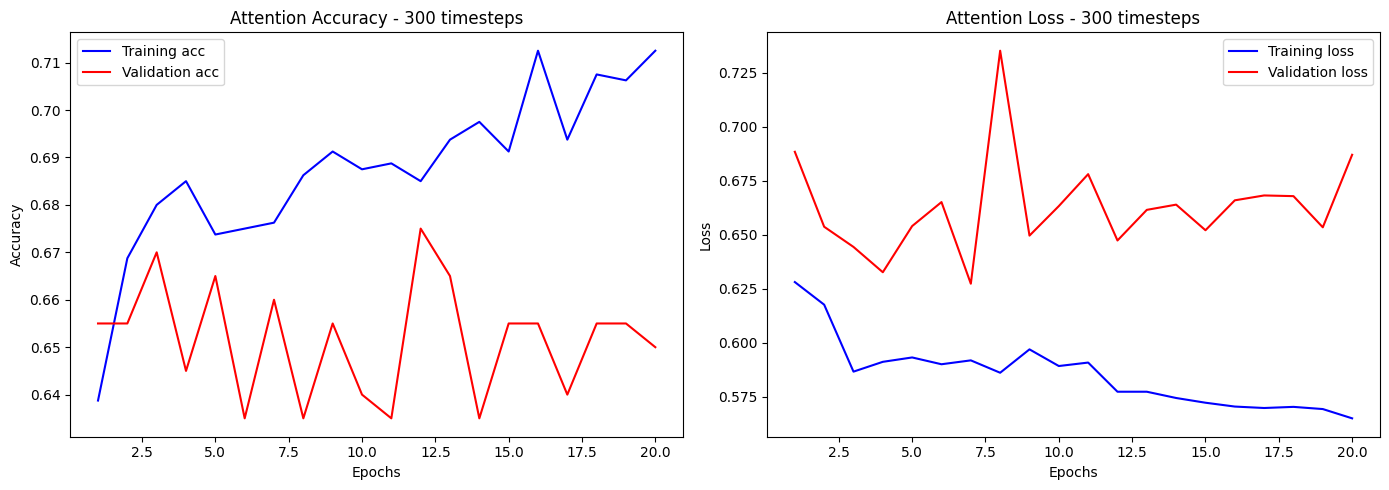

In [80]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history, model_name="", dataset_name=""):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'{model_name} Accuracy - {dataset_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{model_name} Loss - {dataset_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

time_steps_list = [100, 200, 300]
best_lstm_params = {'lstm_units': 64, 'dropout_rate': 0.4, 'batch_size': 32, 'learning_rate': 0.001}
best_attn_params = {'num_heads': 4, 'ff_units': 128, 'dropout_rate': 0.4, 'batch_size': 32, 'learning_rate': 0.001}

# Loop three all 3 datasets
for time_steps in time_steps_list:
    print(f"\nTraining for {time_steps} time steps")

    # Load data
    filename = f"gene_expression_data_{time_steps}.csv"
    X_train, X_test, y_train, y_test = load_and_prepare_data(filename, num_time_steps=time_steps)

    # LSTM Model
    lstm_model = build_lstm_model(
        input_shape=(time_steps, 10),
        lstm_units=best_lstm_params['lstm_units'],
        dropout_rate=best_lstm_params['dropout_rate'],
        learning_rate=best_lstm_params['learning_rate']
    )

    lstm_history = lstm_model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=best_lstm_params['batch_size'],
        validation_data=(X_test, y_test),
        verbose=0
    )

    plot_training_history(lstm_history, model_name="LSTM", dataset_name=f"{time_steps} timesteps")

    # Attention Model
    attn_model = build_attention_model(
        input_shape=(time_steps, 10),
        num_heads=best_attn_params['num_heads'],
        ff_units=best_attn_params['ff_units'],
        dropout_rate=best_attn_params['dropout_rate'],
        learning_rate=best_attn_params['learning_rate']
    )

    attn_history = attn_model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=best_attn_params['batch_size'],
        validation_data=(X_test, y_test),
        verbose=0
    )

    plot_training_history(attn_history, model_name="Attention", dataset_name=f"{time_steps} timesteps")

● Finally, create grouped bar plots to compare the final validation accuracies of the LSTM and Attention models across the three datasets.

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


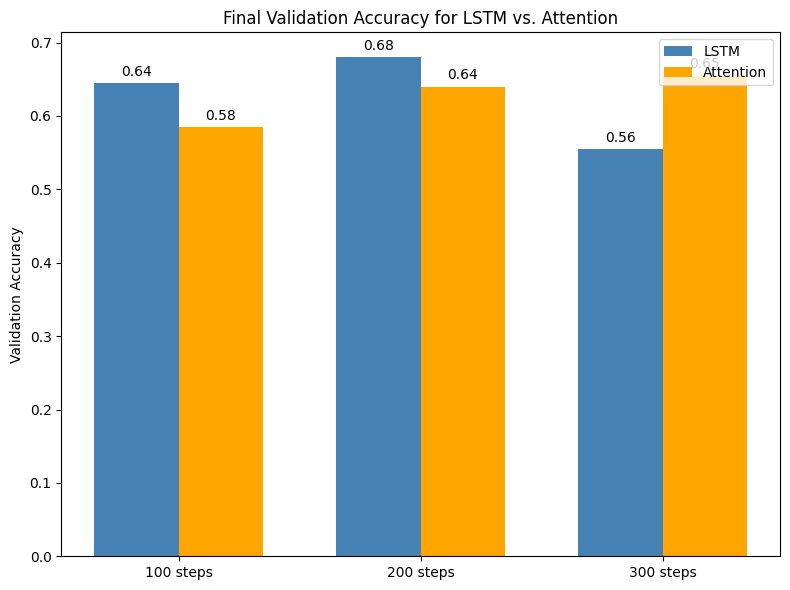

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Collect final validation accuracies
val_accuracies_lstm = []
val_accuracies_attn = []

for time_steps in time_steps_list:
    filename = f"gene_expression_data_{time_steps}.csv"
    X_train, X_test, y_train, y_test = load_and_prepare_data(filename, num_time_steps=time_steps)

    lstm_model = build_lstm_model(
        input_shape=(time_steps, 10),
        lstm_units=best_lstm_params['lstm_units'],
        dropout_rate=best_lstm_params['dropout_rate'],
        learning_rate=best_lstm_params['learning_rate']
    )
    lstm_history = lstm_model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=best_lstm_params['batch_size'],
        validation_data=(X_test, y_test),
        verbose=0
    )
    val_accuracies_lstm.append(lstm_history.history['val_accuracy'][-1])

    attn_model = build_attention_model(
        input_shape=(time_steps, 10),
        num_heads=best_attn_params['num_heads'],
        ff_units=best_attn_params['ff_units'],
        dropout_rate=best_attn_params['dropout_rate'],
        learning_rate=best_attn_params['learning_rate']
    )
    attn_history = attn_model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=best_attn_params['batch_size'],
        validation_data=(X_test, y_test),
        verbose=0
    )
    val_accuracies_attn.append(attn_history.history['val_accuracy'][-1])

# Make bar charts
x = np.arange(len(time_steps_list))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, val_accuracies_lstm, width, label='LSTM', color='steelblue')
bars2 = ax.bar(x + width/2, val_accuracies_attn, width, label='Attention', color='orange')

# Add accuracy values above bars
for i in range(len(x)):
    ax.text(x[i] - width/2, val_accuracies_lstm[i] + 0.01, f"{val_accuracies_lstm[i]:.2f}", ha='center')
    ax.text(x[i] + width/2, val_accuracies_attn[i] + 0.01, f"{val_accuracies_attn[i]:.2f}", ha='center')

ax.set_xticks(x)
ax.set_xticklabels([f'{ts} steps' for ts in time_steps_list])
ax.set_ylabel('Validation Accuracy')
ax.set_title('Final Validation Accuracy for LSTM vs. Attention')
ax.legend()
plt.tight_layout()
plt.show()


# Q5: Analysis and Discussion 

Validation Accuracy for LSTM (100, 200, 300): 0.64, 0.56, 0.68

Valiidation Accuracy for Attention (100, 200, 300): 0.58, 0.64, 0.65

● Analyze how varying the sequence length (100, 200, and 300 time steps) affects the performance of your models: 

For the LSTM model, longest sequence (length = 300) had the highest validation accuracy (acc = 0.68), whereas the middle sequence (length = 200) had the lowest validation accuracy (acc = 0.56). For the Attention model, the longest sequence (length = 300) also had the highest validation accuracy (acc = 0.65), whereas the shortest sequence length (length = 100) had the lowest validation accuracy (acc = 0.58). Thus, it seems that having a longer sequence length increases the accuracy, and thus performance, of both the LSTM and Attention mod. 

● Compare the performance of the LSTM and Attention-based models, and determine which model performs better on longer sequences. Discuss potential reasons for your observations, considering the differences in how each architecture processes temporal information:

The validation accuracy for the LSTM model ranged from 0.56 to 0.68, whereas the validation accuracy for the Attention model ranged from 0.58 to 0.65. Thus, they had similar accuracy rates, but the LSTM model performed better overall. The highest validation accuracy achieved was by the LSTM model (acc = 0.68), when the sequence length = 300; hence, it appears that the LSTM model performs better on longer sequences. Though, the Attention model showed an upward trend in performance as sequence length increased, highlighting its strength in capturing global context. With further tuning, it could outperform LSTM with data involving longer sequences.


LSTMs process sequences sequentially, maintaining a hidden state that evolves over time. This can help capture local temporal dependencies  especially with longer sequences. However, LSTMs are limited by their reliance on a single hidden state, which can bottleneck information.
In contrast, attention models allow the model to directly access all positions in the sequence, which helps with long-range dependencies. 
However, they may require more data or fine-tuning to outperform LSTMs, especially on shorter sequences. Thus, the LSTM may have overperformed the Attention model in this case because the LSTM's architecture may have been better suited to leverage the long sequences. 